### Importing Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier,VotingClassifier,StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D
import gensim
import spacy
import nltk

C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


##### Load the files


In [4]:
Train = pd.read_csv('Train.csv')
Test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')

In [5]:
Train.head()

,Tweet_ID,tweet,type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence
1,ID_00395QYM,he thought the word raped means sex and told m...,sexual_violence
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,ID_004F7516,Chessy Prout can do better by telling the trut...,sexual_violence


In [6]:
def seed_all(seed=42):
    import random
    from tensorflow.random import set_seed
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    set_seed(seed)

## EDA


In [7]:
data = pd.concat([Train,Test])

In [8]:
Train.shape, Test.shape

((39650, 3), (15581, 2))

C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type', ylabel='count'>

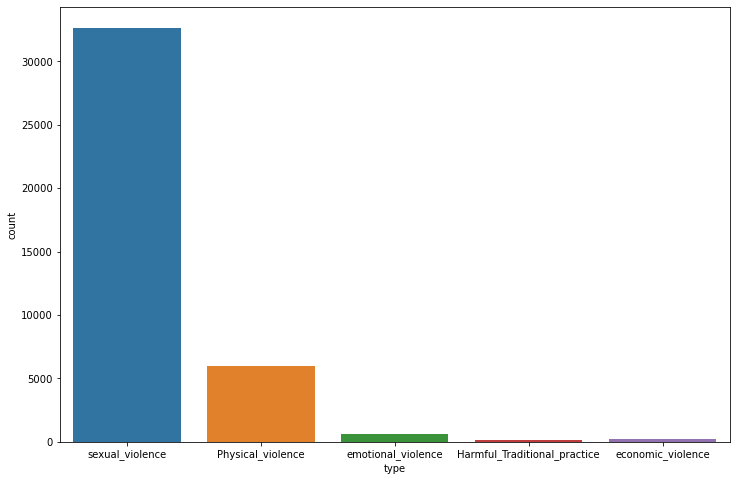

In [9]:
plt.figure(figsize=(12,8))
sns.countplot(data['type'])

In [8]:
data['type'].value_counts(normalize=True)

sexual_violence                 0.823405
Physical_violence               0.149962
emotional_violence              0.016419
economic_violence               0.005473
Harmful_Traditional_practice    0.004741
Name: type, dtype: float64

### Preprocessing

In [9]:
from sklearn.utils import resample
from sklearn.base import TransformerMixin
from math import ceil
class OverSample(TransformerMixin):
    def __init__(self, major_cat, category):
        self.category = category
        self.major_cat = major_cat
    def fit_transform(self, df, y=None):
        X = df.copy()
        major = self.major_cat
        len_major = X[X['type']== major].shape[0]
        df1 = X[X['type']== major]
        for cat in self.category:
            cat_df = X[X['type']==cat]
            resample_df = resample(cat_df, n_samples=len_major, replace=True, random_state=42)
            df1 = pd.concat([df1[df1['type'] != cat],resample_df])
        resampled = df1.values
        """for cat in resample_df.columns:
            len_cat = resample_df[resample_df['type']==cat].shape[0] 
            if len_cat > 0.5 * len_major:
                n_drop = len_cat - len_major"""
        np.random.shuffle(resampled)
        return pd.DataFrame(resampled, columns=X.columns)

In [11]:
oversample = OverSample('sexual_violence', category=Train['type'].unique()[1:])
Train_df = oversample.fit_transform(Train)

C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type', ylabel='count'>

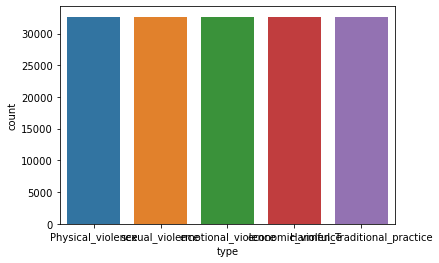

In [122]:
sns.countplot(Train_df['type'])

In [124]:
Train_df.shape

(163240, 3)

C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type', ylabel='count'>

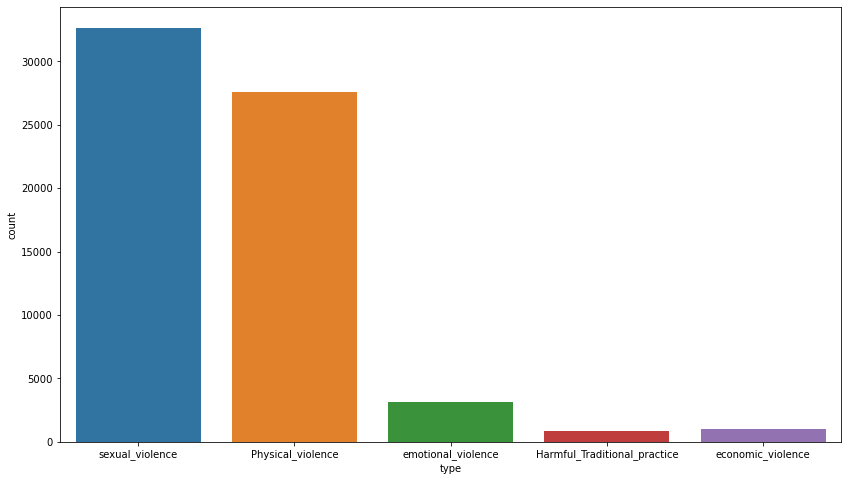

In [106]:
plt.figure(figsize=(14,8))
sns.countplot(Train_df['type'])

In [10]:
tfidf = TfidfVectorizer()
tfidf.fit(Train['tweet'])
vectorized_train = tfidf.transform(Train['tweet'])
vectorized_test = tfidf.transform(Test['tweet'])

In [21]:
#X_sampled, y_sampled = oversample.fit_resample(vectorized_train,Train['type'])

C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type', ylabel='count'>

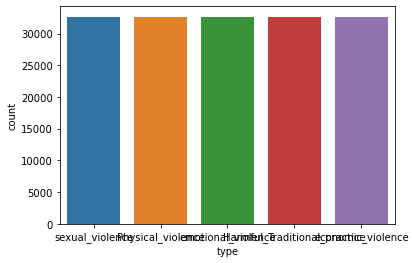

In [24]:
sns.countplot(y_sampled)

In [40]:
vectorized_train

<39650x37282 sparse matrix of type '<class 'numpy.float64'>'
	with 1230816 stored elements in Compressed Sparse Row format>

In [11]:
target = Train['type']
encoder = LabelEncoder()
target = encoder.fit_transform(target)

C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

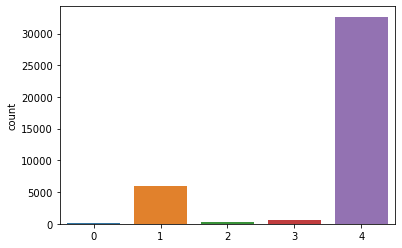

In [12]:
sns.countplot(target)

In [13]:
encode_map = {code:label_ for code,label_ in enumerate(encoder.classes_)}

In [60]:
encode_map

{0: 'Harmful_Traditional_practice',
 1: 'Physical_violence',
 2: 'economic_violence',
 3: 'emotional_violence',
 4: 'sexual_violence'}

In [44]:
encoder.classes_

array(['Harmful_Traditional_practice', 'Physical_violence',
       'economic_violence', 'emotional_violence', 'sexual_violence'],
      dtype=object)

what kind of words appear most in each type of tweet

In [14]:
import string
from nltk.corpus import stopwords
punctuation = string.punctuation
st_words = stopwords.words('english')

excludes = list(punctuation) + st_words

In [15]:
from nltk.stem import WordNetLemmatizer
lemmatize = WordNetLemmatizer().lemmatize

In [47]:
# get the most common word accros tweets of the same type
from nltk.stem import WordNetLemmatizer
lemmatize = WordNetLemmatizer().lemmatize
def get_most_common(df,type_,n_words=None):
    
    X = df.copy()
    X_type_ = X[X['type'] == type_]
    tweets = list(X_type_['tweet'].values)
    text = nltk.word_tokenize(' '.join(tweets).lower())
    dist = nltk.FreqDist(text)
    word_freq = [(word,dist[word]) for word in dist.keys() if word.isalpha()]
    freq = np.array([word[1] for word in word_freq])
    print(freq.sum())
    mean = freq.mean()
    std = freq.std()
    if std == 0:
        std = mean
        
    word_zscore = []
    for word in word_freq: 
        zscore = round((dist[word[0]]-mean/std),4)
        word_zscore.append((word[0],word[1],zscore)) 
    
    if n_words == None:
        n_words = len(word_freq)
        
    return sorted(word_zscore, key=lambda x: x[1], reverse=True)[:n_words]
    

In [48]:
def flag(df,n_words=3):
    X = df.copy()
    X['flag'] = 0
    most_common = {} 
    types_ = df['type'].unique()
    for type_ in types_:
        common_words =  get_most_common(df,type_,n_words)
        most_common[type_] = [word[0] for word in common_words]
    
    i = 0
    for row in X.iterrows():
        
        flags = []
        text = row[1]['tweet']
        for type_ in types_:
            
            common_ = most_common[type_]
            for word in common_:

                if word in text.lower():
                    flags.append(type_)
                i += 1
        
        X['flag'].iloc[row[0]] = list(set(flags))
        
    return X

In [49]:
import string
from nltk.corpus import stopwords
punctuation = string.punctuation
st_words = stopwords.words('english')

excludes = list(punctuation) + st_words

class FlagTweets():
    def __init__(self,labels, n_words=3):
        self.labels = labels
        self.n_words  = n_words # no of most common Words to return
        self.fracs = {} # z-score of word frequency
        
        
    # get the most common word accros tweets of the same type
    def _get_most_common(self,df,type_,n_words=None):

        X = df.copy()
        X_type_ = X[X['type'] == type_]
        tweets = list(X_type_['tweet'].values)
        text = nltk.word_tokenize(' '.join(tweets).lower())
        dist = nltk.FreqDist(text)
        word_freq = [(word,dist[word]) for word in dist.keys() if word.lower() not in excludes and word.isalpha()]
        freq = np.array([word[1] for word in word_freq])
        freq_sum = freq.sum()
        #std = freq.std()
        #if std == 0:
        #    std = mean

        word_frac = []
        for word in word_freq: 
            #zscore = round((dist[word[0]]-mean/std),4)
            frac = round((dist[word[0]]/freq_sum),4)
            word_frac.append((word[0],word[1],frac))

        if n_words == None:
            n_words = len(word_freq)
                             
        self.fracs[type_] = word_frac
        return sorted(word_frac, key=lambda x: x[1], reverse=True)[:n_words]
    
    def fit(self,df,y=None):
        X = df.copy()
        
        most_common = {} 
        types_ = self.labels
        for type_ in types_:
            common_words =  self._get_most_common(X,type_,self.n_words)
            most_common[type_] = [(word[0],word[2]) for word in common_words]
        self.n_common = most_common
        
        return self
    
    def predict(self,df):
        X = df.copy()
        X['flags'] = 'Unknown'
        for row in X.iterrows():
        
            flags = []
            
            text = row[1]['tweet']
            for type_ in self.labels:

                common_ = self.n_common[type_]
                for word in common_:
                    
                    if word[0] in text.lower():
                        flags.append((type_,word[1]))
            flags =  list(set(flags))           
            if len(flags) > 1:
                likely = max(flags, key=lambda x: x[1])
                flag = likely[0]
            elif len(flags) == 1:
                flag = flags[0][0]
                
            X['flags'].iloc[row[0]] = flag
        
        return X
            


In [50]:
flag = FlagTweets(Train['type'].unique(), 10)
flag.fit(Train)

In [51]:
flagged_train = flag.predict(Train)
flagged_test = flag.predict(Test)

In [26]:
flagged_test.head(15)

,Tweet_ID,tweet,flags
0,ID_0095QL4S,"because he was my boyfriend, and if I said no,...",Harmful_Traditional_practice
1,ID_00DREW5O,"lol no, I'm telling you it's not legal. It's l...",Harmful_Traditional_practice
2,ID_00E9F5X9,Somalia's semi-autonomous Puntland region has ...,Harmful_Traditional_practice
3,ID_00G9OSKZ,University of Cape Coast students being robbed...,sexual_violence
4,ID_00HU96U6,"""Somebody came up behind him and stabbed him i...",economic_violence
5,ID_00IJ4SAW,"Sending you hugs. I was raped by a boyfriend,s...",sexual_violence
6,ID_00J80GL8,he stabbed you with a knife,sexual_violence
7,ID_00L0E289,MY FKNG TEACHER HUMILIATED ME AGAIN SHE PREACH...,emotional_violence
8,ID_00N24MZN,1988 I was anally raped while I was asleep by ...,sexual_violence
9,ID_00V2TOUW,29/9/20:A rape victim was cremated without the...,sexual_violence


In [37]:
flagged_test['flags'].value_counts(normalize=True)

sexual_violence                 0.500738
Harmful_Traditional_practice    0.263462
economic_violence               0.105577
emotional_violence              0.066427
Physical_violence               0.063796
Name: flags, dtype: float64

In [38]:
flagged_train['type'].value_counts(normalize=True)

sexual_violence                 0.823405
Physical_violence               0.149962
emotional_violence              0.016419
economic_violence               0.005473
Harmful_Traditional_practice    0.004741
Name: type, dtype: float64

In [52]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(drop='first')
ntrain = flagged_train.shape[0]
flag_data = pd.concat([flagged_train[['flags']],flagged_test[['flags']]])
one_hot.fit(flag_data[['flags']])
one_hot_data = one_hot.transform(flag_data[['flags']])
one_hot_train = one_hot_data[:ntrain]
one_hot_test = one_hot_data[ntrain:]

In [53]:
one_hot_train

<39650x4 sparse matrix of type '<class 'numpy.float64'>'
	with 39290 stored elements in Compressed Sparse Row format>

In [55]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
oversample.fit_resample

In [61]:
from scipy import sparse as sp
train, target = oversample.fit_resample(sp.csr_matrix(sp.hstack((vectorized_train,one_hot_train))),y=target)
test = sp.csr_matrix(sp.hstack((vectorized_test,one_hot_test)))

In [65]:
train.shape,test.shape

((163240, 37286), (15581, 37286))

In [67]:
naive_model  = MultinomialNB()
log_model = LogisticRegression(random_state=42)
svc = SVC(kernel='linear', random_state=42)
light = LGBMClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
bag = BaggingClassifier(log_model, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(train,target, test_size=0.3, random_state=42)

Buiding models

In [68]:
naive_model.fit(X_train,y_train)
nb_preds = naive_model.predict(X_test)
print('Accuracy:>', accuracy_score(y_test,nb_preds))

Accuracy:> 0.9938127909826023


In [29]:
log_model.fit(X_train,y_train)
lg_preds = log_model.predict(X_test)
print('Accuracy:>', accuracy_score(y_test,lg_preds))

Accuracy:> 0.9998162215143347


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [99]:
light.fit(X_train,y_train)
lt_preds = light.predict(X_test)
lt_tr_preds = light.predict(X_train)
print('Train Score:', accuracy_score(y_train,lt_tr_preds))
print('Accuracy:>', accuracy_score(y_test,lt_preds))

Train Score: 0.9999279409115475
Accuracy:> 0.9990752416981925


In [64]:
svc.fit(X_train,y_train)
sv_preds = svc.predict(X_test)
sv_tr_preds = svc.predict(X_train)
print('Train Score:', accuracy_score(y_train,sv_tr_preds))
print('Accuracy:>', accuracy_score(y_test,sv_preds))

Train Score: 0.9997117636461899
Accuracy:> 0.9978142076502732


In [82]:
rfc.fit(X_train,y_train)
rf_preds = rfc.predict(X_test)
rf_tr_preds = rfc.predict(X_train)
print('Train Score:', accuracy_score(y_train,rf_tr_preds))
print('Accuracy:>', accuracy_score(y_test,rf_preds))

Train Score: 0.9999639704557738
Accuracy:> 0.9923497267759562


In [110]:
bag.fit(X_train,y_train)
bg_preds = bag.predict(X_test)
bg_tr_preds = bag.predict(X_train)
print('Train Score:', accuracy_score(y_train,bg_tr_preds))
print('Accuracy:>', accuracy_score(y_test,bg_preds))

Train Score: 0.9999639704557738
Accuracy:> 0.9993274485077763


In [107]:
#preds_nb = naive_model.predict(vectorized_test)
#preds_lg = log_model.predict(vectorized_test)
#preds_sv = svc.predict(vectorized_test)
#preds_lt = light.predict(vectorized_test)
#preds_rf = rfc.predict(vectorized_test)
preds_bg = bag.predict(vectorized_test)

Using kfold cross validation

In [69]:
from scipy.stats import mode
def cross_val(model,X,y,test,random_state = 42,fold = 2):
    tot_val_pred = []
    tot_test_pred = np.zeros((fold,test.shape[0]))
    y_copy = y.copy()
    kf = KFold(n_splits=fold, random_state=random_state, shuffle=True)
    i = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
       
        model.fit(X_train,y_train)
        y_pred =  model.predict(X_test)
        y_copy[test_index] = y_pred
        print(accuracy_score(y_pred,y_test))
        tot_test_pred[i] = model.predict(test)
        i += 1
    print('Val Accuracy', accuracy_score(y_copy,y))
    tot_test_pred = mode(tot_test_pred,axis = 0)[0][0]
    return y_copy,tot_test_pred
        

In [441]:
val_pred, preds_nb = cross_val(naive_model, train,target, test, fold=10)

0.9636822194199244
0.964186633039092
0.9662042875157629
0.9707440100882724
0.9687263556116015
0.9646910466582598
0.969482976040353
0.9692307692307692
0.9699873896595208
0.9639344262295082
Val Accuracy 0.9670870113493064


In [70]:
val_pred, preds_lg = cross_val(log_model, train,target, test, fold=10)

C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9979171771624602


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9980396961529037


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9977333986767949


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9974883606959078


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9981009556481255


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9977946581720166


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9981009556481255


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9977333986767949


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9979784366576819


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9984072531242343
Val Accuracy 0.9979294290615045


In [29]:
val_pred, preds_sv = cross_val(svc,train,target, test, fold=10)

0.9979823455233291
0.9974779319041615
0.9987389659520807
0.9989911727616646
0.998234552332913
0.9969735182849937
0.9987389659520807
0.9974779319041615
0.998234552332913
0.9987389659520807
Val Accuracy 0.9981588902900378


In [34]:
val_pred, preds_lt = cross_val(light, vectorized_train,target, vectorized_test, fold=10)

0.9998774810095565
0.9999387405047783
1.0
1.0
1.0
0.9998774810095565
1.0
0.9999387405047783
0.9999387405047783
0.9998162215143347
Val Accuracy 0.9999387405047783


In [449]:
val_pred, preds_xg = cross_val(xgb, train,target, test, fold=10)

C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1.0


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9992433795712484


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9989911727616646


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:45:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9987389659520807


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9997477931904162


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9997477931904162


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9994955863808322


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9989911727616646


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1.0


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9992433795712484
Val Accuracy 0.9994199243379571


In [458]:
val_pred, preds_bg = cross_val(bag,train,target, test, fold=10)

0.9949558638083228
0.9962168978562421


C:\Users\MUHAMMAD\anaconda3\envs\KerasEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9954602774274905
0.994703656998739
0.9949558638083228
0.9949558638083228
0.9959646910466583
0.9944514501891552
0.994703656998739
0.9954602774274905
Val Accuracy 0.9951828499369483


### Creating submission 

In [443]:
ss['type'] = preds_nb
ss['type'] = ss['type'].map(encode_map)
ss[['Tweet_ID','type']].to_csv('./submissions/submission2_cv_nb.csv', index=False)

In [71]:
ss['type'] = preds_lg
ss['type'] = ss['type'].map(encode_map)
ss[['Tweet_ID','type']].to_csv('./submissions/submission-smote-cv_lg.csv', index=False)

In [30]:
ss['type'] = preds_sv
ss['type'] = ss['type'].map(encode_map)
ss[['Tweet_ID','type']].to_csv('./submissions/submission-cv_svc.csv', index=False)

In [35]:
ss['type'] = preds_lt
ss['type'] = ss['type'].map(encode_map)
ss[['Tweet_ID','type']].to_csv('./submissions/submission6_lgbm.csv', index=False)

In [459]:
ss['type'] = preds_bg
ss['type'] = ss['type'].map(encode_map)
ss[['Tweet_ID','type']].to_csv('./submissions/submission2-_bag.csv', index=False)

In [450]:
ss['type'] = preds_xg
ss['type'] = ss['type'].map(encode_map)
ss[['Tweet_ID','type']].to_csv('./submissions/submission1-xgb.csv', index=False)

In [24]:
preds_nb

array([4., 4., 4., ..., 4., 4., 4.])